In [15]:
%matplotlib inline
import pandas as ps
import numpy as np
import matplotlib.pyplot as plt
import collections
import sklearn
import seaborn as sns; sns.set()

In [16]:
train_orig = ps.read_csv('Challenge1_Train_aa.csv')

/Users/Sanchita/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
train_orig.tail(2)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,flag1,flag2
69998,92616606,6019164,Caucasian,Male,6,NaN,1,1,6,2,...,No,No,No,No,No,No,Ch,Yes,0,0
69999,277875756,6734736,Asian,Male,6,NaN,2,13,4,7,...,No,No,No,No,No,No,No,No,0,0


In [18]:
# Remove features with >70% missing data and some based on domain knowledge 
remv_col = [0,5,10,11,18,19,21,22,24,26]
train_temp = train_orig.drop(train_orig.columns[remv_col], axis=1)

In [7]:
train_temp.dtypes

patient_nbr                  int64
race                        object
gender                      object
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
long_label_1                object
long_label_2                object
short_label_3               object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide         

In [19]:
# Separate numeric and non-numeric data
train_num = train_temp.select_dtypes(include=['int64']).copy()
train_obj = train_temp.select_dtypes(include=['object']).copy()

In [20]:
train_num.tail(2)
train_obj.tail(2)

,race,gender,long_label_1,long_label_2,short_label_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,...,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed
69998,Caucasian,Male,'(996-999) COMPLICATIONS OF SURGICAL AND MEDIC...,NaN,NaN,None,None,No,Up,No,...,No,No,No,No,No,No,No,No,Ch,Yes
69999,Asian,Male,NaN,NaN,NaN,None,None,No,No,No,...,No,No,No,No,No,No,No,No,No,No


In [21]:
# Encode missing data from '?' as missing for categorical variables
train_obj = train_obj.replace('?', 'Missing')
train_obj = train_obj.where(ps.notnull(train_obj),"Missing")

In [22]:
# One-hot encoding for variables that have very few categories
train_obj = ps.get_dummies(train_obj, columns=['race', 'gender', 'change', 'diabetesMed'])

In [23]:
# Label encoding for variables with many categories
for i in train_obj.columns.values[:-12]: 
    train_obj[i] = train_obj[i].astype('category')
    train_obj[i] = train_obj[i].cat.codes 

In [24]:
train_obj.tail()

,long_label_1,long_label_2,short_label_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,...,race_Caucasian,race_Hispanic,race_Missing,race_Other,gender_Female,gender_Male,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
69995,102,104,18,2,2,1,1,1,1,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
69996,102,104,18,2,2,2,1,1,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
69997,102,104,18,2,0,1,1,1,1,1,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
69998,102,104,18,2,2,1,3,1,1,1,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
69999,104,104,18,2,2,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [25]:
# Convert labels from numeric as category for classification
train_num['flag1'] = train_num['flag1'].astype('category')
train_num['flag1'] = train_num['flag1'].cat.codes
train_num['flag2'] = train_num['flag2'].astype('category')
train_num['flag2'] = train_num['flag2'].cat.codes

In [26]:
# Merge all features to create training data
train_data = ps.concat([train_num, train_obj],axis=1)

In [27]:
# Join label information post processing
tt = train_data.columns.tolist()
tt.insert(len(tt),tt.pop(tt.index('flag2')))
tt.insert(len(tt),tt.pop(tt.index('flag1')))

In [28]:
# Separate features and labels and create training and test sets
int_df = train_data[tt]
all_features = int_df.columns.values[2:-2]
from sklearn.cross_validation import train_test_split
train, test = train_test_split(int_df, test_size=0.2)

/Users/Sanchita/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
array = train.values
X = array[:,2:-2]
Y = array[:,-2]

# Random Search Cross Validation

In [30]:
# Split training data into train and validation sets using cross-validation
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, random_state=42)

In [18]:
X_new.shape

((56000, 16), None)

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Random Hyperparameter Grid

We will try adjusting the following set of hyperparameters:

1. n_estimators = number of trees in the foreset
2. max_features = max number of features considered for splitting a node
3. max_depth = max number of levels in each decision tree
4. min_samples_split = min number of data points placed in a node before the node is split
5. min_samples_leaf = min number of data points allowed in a leaf node
6. bootstrap = method for sampling data points (with or without replacement)

In [22]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [45]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] max_features=log2, n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_depth=30, bootstrap=True 
[CV] max_features=log2, n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_depth=30, bootstrap=True 
[CV] max_features=log2, n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_depth=30, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=True 
[CV] max_features=log2, n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_depth=10, bootstrap=False 
[CV] max_features=log2, n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_depth=10, bootstrap=False 
[CV]  max_features=log2, n

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.9min


[CV]  max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=70, bootstrap=True, total=  24.0s
[CV] max_features=log2, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_depth=90, bootstrap=False 
[CV]  max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=70, bootstrap=True, total=  24.2s
[CV] max_features=log2, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_depth=90, bootstrap=False 
[CV]  max_features=auto, n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_depth=10, bootstrap=False, total= 1.6min
[CV] max_features=log2, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_depth=90, bootstrap=False 
[CV]  max_features=auto, n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_depth=10, bootstrap=False, total= 1.6min
[CV] max_features=log2, n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False 
[CV]  max_features=auto,

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 28.3min


[CV] max_features=auto, n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_depth=50, bootstrap=False 
[CV]  max_features=auto, n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_depth=90, bootstrap=True, total= 2.5min
[CV]  max_features=auto, n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_depth=90, bootstrap=True, total= 2.5min
[CV] max_features=auto, n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_depth=50, bootstrap=False 
[CV] max_features=auto, n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_depth=50, bootstrap=False 
[CV]  max_features=log2, n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_depth=70, bootstrap=False, total= 1.4min
[CV] max_features=auto, n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_depth=50, bootstrap=False 
[CV]  max_features=log2, n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_depth=110, bootstrap=False, total=  50.0s
[CV] max_features=

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 57.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'max_features': ['auto', 'log2'], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [46]:
# The best parameters from fitting the random search
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1800}

# Evaluate Random Search

In [54]:
#def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

from sklearn.metrics import accuracy_score
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(Xtrain, ytrain)
base_accuracy = evaluate(base_model, Xtest, ytest)
yfit = base_model.predict(Xtest)
accu = accuracy_score(ytest, yfit)
print("Mean accuracy score: %d", accu)

Model Performance
Average Error: 0.4041 degrees.
Accuracy = nan%.
Mean accuracy score: %d 0.595928571429


In [56]:
best_random = rf_random.best_estimator_
best_random.fit(Xtrain, ytrain)
yfit = best_random.predict(Xtest)
accu = accuracy_score(ytest, yfit)
print("Mean accuracy score: %d", accu)

Mean accuracy score: %d 0.638571428571


# Grid Search with Cross Validation

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search.

In [70]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1200, 1600, 2000, 2200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(Xtrain, ytrain)
grid_search.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV] max_features=log2, n_estimators=2000, min_samples_split=2, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.1min


[CV]  max_features=log2, n_estimators=2200, min_samples_split=3, max_depth=80, min_samples_leaf=3, bootstrap=True, total= 1.9min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1200, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True, total= 1.0min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True, total= 1.4min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=4, max_depth=80, min_samples_leaf=3, bootstrap=True, total= 1.4min
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=80, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_e

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 32.1min


[CV]  max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=90, min_samples_leaf=3, bootstrap=True, total= 1.9min
[CV] max_features=log2, n_estimators=2200, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True, total= 1.3min
[CV] max_features=log2, n_estimators=2200, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True, total= 1.3min
[CV] max_features=log2, n_estimators=1200, min_samples_split=3, max_depth=90, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=2, max_depth=90, min_samples_leaf=4, bootstrap=True, total= 1.3min
[CV] max_features=log2, n_estimators=1200, min_samples_split=3, max_depth=90, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=log2, n_e

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 76.3min


[CV]  max_features=log2, n_estimators=1200, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True, total= 1.1min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=2200, min_samples_split=3, max_depth=110, min_samples_leaf=3, bootstrap=True, total= 1.9min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True, total= 1.4min
[CV] max_features=log2, n_estimators=2200, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True 
[CV]  max_features=log2, n_estimators=1600, min_samples_split=4, max_depth=110, min_samples_leaf=3, bootstrap=True, total= 1.4min
[CV] max_features=log2, n_estimators=1200, min_samples_split=2, max_depth=110, min_samples_leaf=4, bootstrap=True 
[CV]  max_features=l

[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 94.5min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 1600}

In [78]:
# The best parameters from fitting the grid search
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
# As the classes are not balanced, specify that along with other parameters from the grid search
from sklearn.ensemble import RandomForestClassifier
#best_grid = grid_search.best_estimator_
best_grid = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion='gini',
            max_depth=110, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
best_grid.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=110, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=1600, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [47]:
# Get the accuracy on the validation data
from sklearn.metrics import accuracy_score
yfit = best_grid.predict(Xtest)
accu = accuracy_score(ytest, yfit)
print("Mean accuracy score: %d", accu)

Mean accuracy score: %d 0.6385


In [49]:
# Get probability estimates for AUC computation on the validation data
yprob = best_grid.predict_proba(Xtest)
yprob[1:5,:]
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(ytest,yprob[:,1])
print("AUC: %d", metrics.auc(fpr,tpr))

AUC: %d 0.688801248975


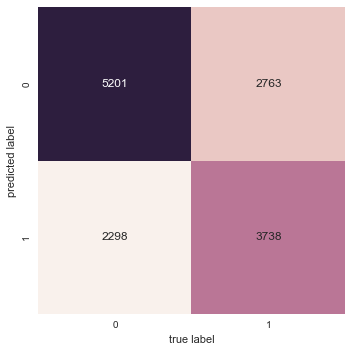

In [50]:
# Get confusion matrix for the valiidataion data
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [51]:
# Get the test set
test.shape
array = test.values
Xt = array[:,2:-2]
yt = array[:,-2]

In [52]:
# Get the accuracy on the test data
from sklearn.metrics import accuracy_score
yfit = best_grid.predict(Xt)
accu = accuracy_score(yt, yfit)
print("Mean accuracy score: %d", accu)

Mean accuracy score: %d 0.633571428571


In [53]:
# Get probability estimates for AUC computation on the test data
yprob = best_grid.predict_proba(Xtest)
yprob[1:5,:]
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(ytest,yprob[:,1])
print("AUC: %d", metrics.auc(fpr,tpr))

AUC: %d 0.688801248975


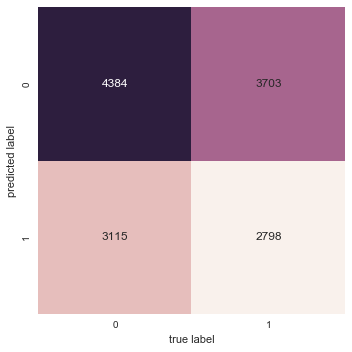

In [54]:
# Get confusion matrix for the test data
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')